#Libs

In [ ]:
#@title Install libs
!pip install catboost

!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib
!pip install ccxt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.0 MB/s eta 0:00:00
--2024-11-08 05:19:07--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2024-11-08 05:19:07--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://netactuate.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz?viasf=1 [following]
--2024-11-08 05:19:07--  http://netactuate.dl.s

In [ ]:
from logging import warning
#@title Load libs
import numpy as np

# Data Management
import pandas as pd

# Machine Learning
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

# ensemble
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier

#Sampling Methods
from imblearn.over_sampling import ADASYN

#Scaling
from sklearn.preprocessing import MinMaxScaler

# Binary Classification Specific Metrics
from sklearn.metrics import RocCurveDisplay as plot_roc_curve

# General Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import ConfusionMatrixDisplay


# Reporting
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from xgboost import plot_tree

from hyperopt import fmin, tpe, hp
from pandas_datareader.data import DataReader

import json
from datetime import datetime
import talib as ta
import ccxt

import matplotlib.pyplot as plt

from tqdm import tqdm
import pickle as pk
import joblib

#Functions

In [ ]:
#@title Get data from CCXT

#timeframe format must be like that: '2022-07-21 00:00:00'
#timeframe format: '15m'
#ticker format: 'BTC/USDT'
def get_data(exch: str, start_time: str, timeframe: str, ticker: str) -> pd.DataFrame:
    ex = getattr (ccxt, exch) ()
    from_ts = ex.parse8601(start_time)
    ohlcv = ex.fetch_ohlcv(ticker, timeframe, since=from_ts, limit=1000)

    while True:
        from_ts = ohlcv[-1][0]
        new_ohlcv = ex.fetch_ohlcv(ticker, timeframe, since=from_ts, limit=1000)
        ohlcv.extend(new_ohlcv)
        if len(new_ohlcv)!=1000:
          break
    df = pd.DataFrame(ohlcv, columns=['date', 'open', 'high', 'low', 'close', 'volume'])
    df['date'] = pd.to_datetime(df['date'], unit='ms')
    df.set_index('date', inplace=True)
    df = df.sort_index(ascending=True)
    return df

In [ ]:
#@title Indicators (for adding to df)
def get_indicators(data, timeframes, volatility_look_back):
    df = data.copy()

    for timeframe in timeframes:
        #for frame_name in frames_names:
            df[f'ATR_{timeframe}'] = ta.ATR(df['high'], df['low'], df['close'], timeperiod=timeframe)
            df[f'EMA_{timeframe}'] = ta.EMA(df['close'], timeperiod=timeframe)
            df[f'RSI_{timeframe}'] = ta.RSI(df['close'], timeperiod=timeframe)
            df[f'VWAP_{timeframe}'] = ta.SUM(df['volume'] * (df['high'] + df['low'] + df['close']) / 3, timeperiod=timeframe) / ta.SUM(df['volume'], timeperiod=timeframe)
            df[f'ROC_{timeframe}'] = ta.ROC(df['close'], timeperiod=timeframe)
            df[f'KC_upper_{timeframe}'] = ta.EMA(df['high'], timeperiod=timeframe)
            df[f'KC_middle_{timeframe}'] = ta.EMA(df['low'], timeperiod=timeframe)
            df[f'Donchian_upper_{timeframe}'] = ta.MAX(df['high'], timeperiod=timeframe)
            df[f'Donchian_lower_{timeframe}'] = ta.MIN(df['low'], timeperiod=timeframe)
            macd, macd_signal, _ = ta.MACD(df['close'], fastperiod=(timeframe + 12), slowperiod=(timeframe + 26), signalperiod=(timeframe + 9))
            df[f'MACD_{timeframe}'] = macd
            df[f'MACD_signal_{timeframe}'] = macd_signal
            bb_upper, bb_middle, bb_lower = ta.BBANDS(df['close'], timeperiod=timeframe, nbdevup=2, nbdevdn=2)
            df[f'BB_upper_{timeframe}'] = bb_upper
            df[f'BB_middle_{timeframe}'] = bb_middle
            df[f'BB_lower_{timeframe}'] = bb_lower
            df[f'EWO_{timeframe}'] = ta.SMA(df['close'], timeperiod=(timeframe+5)) - ta.SMA(df['close'], timeperiod=(timeframe+35))



    df["returns"] = (df["close"] / df["close"].shift(volatility_look_back)) - 1
    df["range"] = (df["high"] / df["low"]) - 1
    df["volatility"] = df['returns'].rolling(window=volatility_look_back).std()

    # Volume-Based Indicators
    df['OBV'] = ta.OBV(df['close'], df['volume'])
    df['ADL'] = ta.AD(df['high'], df['low'], df['close'], df['volume'])


    # Momentum-Based Indicators
    df['Stoch_Oscillator'] = ta.STOCH(df['high'], df['low'], df['close'])[0]
    # Calculate the Elliott Wave Oscillator (EWO)
    #df['EWO'] = ta.SMA(df['close'], timeperiod=5) - ta.SMA(df['close'], timeperiod=35)


    # Volatility-Based Indicators
    # df['ATR'] = ta.ATR(df['high'], df['low'], df['close'], timeperiod=14)
    # df['BB_upper'], df['BB_middle'], df['BB_lower'] = ta.BBANDS(df['close'], timeperiod=20, nbdevup=2, nbdevdn=2)
    # df['KC_upper'], df['KC_middle'] = ta.EMA(df['high'], timeperiod=20), ta.EMA(df['low'], timeperiod=20)
    # df['Donchian_upper'], df['Donchian_lower'] = ta.MAX(df['high'], timeperiod=20), ta.MIN(df['low'], timeperiod=20)

    # Trend-Based Indicators
    # df['MA'] = ta.SMA(df['close'], timeperiod=20)
    # df['EMA'] = ta.EMA(df['close'], timeperiod=20)
    df['PSAR'] = ta.SAR(df['high'], df['low'], acceleration=0.02, maximum=0.2)

    return df

In [ ]:
#@title New Mark Function
def get_shifts(df, K=4): #(data, K=4):
    #df=data.copy()
    for i in range(K):
        name_back=f'shift_{i}'
        name_frorward=f'shift_-{i}'
        df[name_back]=df['close'].shift(i)
        df[name_frorward]=df['close'].shift(-i)
    df.dropna(inplace=True)
    #return df

def get_coefs(df, K=4): #data, K=4):
    #df=data.copy()

    #get means
    back_col_names=[f'shift_{i}' for i in range(K)]
    frorward_col_names=[f'shift_-{i}' for i in range(K)]
    back_result=[i.mean() for i in df[back_col_names].values]
    frorward_result=[i.mean() for i in df[frorward_col_names].values]
    df['mean_back']=back_result
    df['mean_frorward']=frorward_result

    #get coefs
    df['coef']=(df['mean_frorward']-df['mean_back'])/df['mean_back']
    #return df

def get_classes(df,std_corrector=1): #data, std_corrector=1):
    #df=data.copy()
    long_thold=df['coef'][df['coef']>=0].mean()-df['coef'][df['coef']>=0].std()/std_corrector
    short_thold=df['coef'][df['coef']<0].mean()+df['coef'][df['coef']<0].std()/std_corrector
    df['class']=0
    df['class'][df['coef']>long_thold]=1
    df['class'][df['coef']<short_thold]=2 #-1
    #return df

def get_lbls(data, K=4, std_corrector=1):
    df=data.copy()
    get_shifts(df, K)
    get_coefs(df, K)
    get_classes(df, std_corrector)

    return df

#Data preparation

In [ ]:
#@title Get data from CCXT

EXCH = 'bitfinex' # @param ['binance','bitfinex','bytetrade','ftx','kraken','poloniex','upbit','acx','bequant','bigone','bitforex','bitkk','bitz','btcalpha','coinex','crex24','digifinex','gateio','hitbtc2','huobipro','huobiru','kucoin','lbank','okex','okex3','stex','upbit','whitebit','zb'] {allow-input: false}
START_DATE = "2024-01-01 00:00:00" #@param {type: "string"}
TIMEFRAME= "15m" #@param {type: "string"}
TICKER= "BTC/USDT" #@param {type: "string"}
five_min_df=get_data(EXCH, START_DATE, TIMEFRAME, TICKER)

print(f'data len: {len(five_min_df)}')
print()
five_min_df.head()

data len: 29978



,open,high,low,close,volume
date,,,,,
2024-01-01 00:00:00,42278.0,42471.0,42278.0,42471.0,3.318336
2024-01-01 00:15:00,42473.0,42547.0,42420.0,42420.0,1.893146
2024-01-01 00:30:00,42405.0,42445.0,42359.0,42414.0,1.357047
2024-01-01 00:45:00,42446.0,42483.0,42419.0,42483.0,0.339710
2024-01-01 01:00:00,42473.0,42473.0,42434.0,42470.0,0.968030


In [ ]:
#@title Add indicators data to df

#set retrospective variables
#shift and rolling window for retunrs and volatility calculation
VOLATILITY_LOOK_BACK = 2 #@param {type: "integer"}

#0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233
timeframes = [2, 4, 6, 8, 10, 12, 14,
              16, 18, 22, 26, 33, 44, 55]

#get calculations and drop rows with missing values
df_w_indicators=get_indicators(five_min_df,
                               timeframes,
                               VOLATILITY_LOOK_BACK)
df_w_indicators.dropna(inplace=True)

inf_mask = np.isinf(df_w_indicators) | np.isnan(df_w_indicators)
df_cleaned = df_w_indicators[~inf_mask.any(axis=1)]
df = df_cleaned.loc[:, ~inf_mask.any(axis=0)]
df.dropna(inplace=True)

df_w_indicators.info()

<ipython-input-4-6e3b5589aec3>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'MACD_{timeframe}'] = macd
<ipython-input-4-6e3b5589aec3>:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'MACD_signal_{timeframe}'] = macd_signal
<ipython-input-4-6e3b5589aec3>:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29835 entries, 2024-01-02 11:45:00 to 2024-11-08 05:15:00
Columns: 222 entries, open to PSAR
dtypes: float64(222)
memory usage: 50.8 MB


In [ ]:
#@title Add target (New)

STD_CORRECTOR = 2 #@param {type: "integer"}
K = 4 #@param {type: "integer"}

df=get_lbls(df_w_indicators, K=K, std_corrector=STD_CORRECTOR)
df=df.reset_index()

keys=list(df_w_indicators.keys())
keys.append('class')
#df.head()
#df['target'].hist()

<ipython-input-5-287cabf11d37>:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['class'][df['coef']>long_thold]=1
<ipython-input-5-287cabf11d37>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

In [ ]:
#@title Rename column "class" to "target" to evoid crashes by old code
df=df[keys]

df.rename(columns={'class': 'target'}, inplace=True)
df

<ipython-input-10-f36d8d03cdcd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'class': 'target'}, inplace=True)


,open,high,low,close,volume,ATR_2,EMA_2,RSI_2,VWAP_2,ROC_2,...,BB_lower_55,EWO_55,returns,range,volatility,OBV,ADL,Stoch_Oscillator,PSAR,target
0,45444.0,45583.0,45437.0,45478.0,7.111698,159.649092,45457.220600,73.631708,45452.736523,0.255721,...,44326.147420,667.816667,0.002557,0.003213,0.001684,300.362272,308.283061,56.989048,45685.990181,0
1,45473.0,45486.0,45283.0,45298.0,7.012764,181.324546,45351.073533,21.162407,45428.003149,-0.308112,...,44459.931746,665.972222,-0.003081,0.004483,0.003987,293.349508,302.306666,54.350439,45656.530770,1
2,45299.0,45477.0,45277.0,45475.0,5.358232,190.662273,45433.691178,67.170553,45379.055611,-0.006597,...,44562.587871,667.111111,-0.000066,0.004417,0.002132,298.707740,307.557734,54.603277,45628.838924,1
3,45471.0,45550.0,45345.0,45523.0,18.476838,197.831136,45493.230393,75.063440,45458.503980,0.496711,...,44664.747219,669.000000,0.004967,0.004521,0.003559,317.184578,321.167502,57.087947,45602.808588,1
4,45518.0,45699.0,45518.0,45662.0,56.825253,189.415568,45605.743464,89.576925,45588.628217,0.411215,...,44764.299011,672.483333,0.004112,0.003976,0.000605,374.009831,354.760331,78.776756,45195.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29824,75776.0,75776.0,75656.0,75769.0,0.343727,131.235515,75774.902612,41.815637,75735.198287,-0.121274,...,75051.493930,317.700000,-0.001213,0.001586,0.001567,342.114593,6362.692994,68.075061,76193.519720,1
29825,75775.0,75884.0,75775.0,75884.0,0.006403,123.117757,75847.634204,82.558650,75735.751514,0.143847,...,75131.547873,321.411111,0.001438,0.001438,0.001875,342.120996,6362.699397,78.809524,76156.768537,1
29826,75885.0,75920.0,75851.0,75920.0,0.205613,96.058879,75895.878068,87.874572,75895.510055,0.199290,...,75206.078292,325.361111,0.001993,0.000910,0.000392,342.326609,6362.905010,89.047619,76122.222424,0
29827,75921.0,76006.0,75921.0,75963.0,0.176665,91.029439,75940.626023,92.983399,75927.655132,0.104106,...,75313.106037,331.138889,0.001041,0.001120,0.000673,342.503274,6362.902931,95.904762,76089.749079,0


<Axes: >

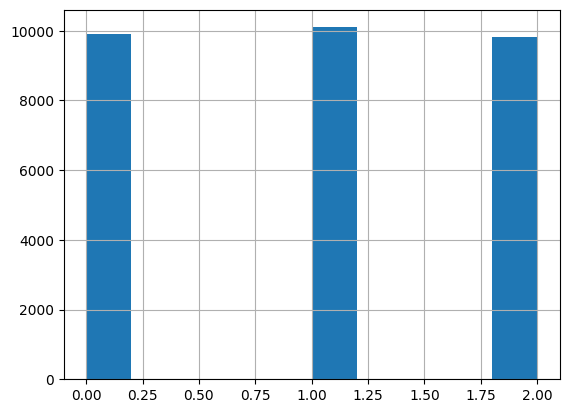

In [ ]:
#@title Look at class balance
df['target'].hist()

#Train

In [ ]:
#@title MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

input=df.iloc[:,1 : -1].copy()
target=df.iloc[:, -1].copy()

scaled_input=scaler.fit_transform(input)

In [ ]:
#@title Train/test split
spliter = int(0.7 * len(scaled_input))
train_input, test_input = scaled_input[:spliter], scaled_input[spliter:]
train_target, test_target = target[:spliter], target[spliter:]

In [ ]:
#@title Set models an Run train
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)
catboost_classifier = CatBoostClassifier(iterations=800,
                                         learning_rate=0.2,
                                         depth=6,
                                         l2_leaf_reg=3,
                                         border_count=64,
                                         bagging_temperature=0.5,
                                         random_strength=0.5,
                                         leaf_estimation_iterations=5,
                                         leaf_estimation_method='Newton',
                                         class_weights=[1, 8, 8],
                                         verbose=0)

# Create a list of tuples containing the classifier name and the classifier object
classifiers = [('Random Forest', rf_classifier),
               ('Gradient Boosting', gb_classifier),
               ('CatBoost', catboost_classifier)]

# Initialize the VotingClassifier with the list of classifiers
voting_classifier = VotingClassifier(estimators=classifiers, voting='soft')  # 'soft' voting for probability-based ensemble

# Train the VotingClassifier on the training data
voting_classifier.fit(train_input, train_target)

VotingClassifier(estimators=[('Random Forest',
                              RandomForestClassifier(random_state=42)),
                             ('Gradient Boosting',
                              GradientBoostingClassifier(random_state=42)),
                             ('CatBoost',
                              <catboost.core.CatBoostClassifier object at 0x7fa2bb3d7af0>)],
                 voting='soft')

In [ ]:
#@title Test (new)
pred_target = voting_classifier.predict(test_input)
accuracy = accuracy_score(test_target, pred_target)
print("Ensemble Accuracy:", accuracy)

Ensemble Accuracy: 0.577606436473349


Classification Report (Entire Dataset):
              precision    recall  f1-score   support

           0       0.59      0.28      0.38      3012
           1       0.60      0.71      0.65      3026
           2       0.55      0.75      0.64      2911

    accuracy                           0.58      8949
   macro avg       0.58      0.58      0.55      8949
weighted avg       0.58      0.58      0.55      8949

Confusion Matrix (Entire Dataset):
[[ 838 1012 1162]
 [ 272 2140  614]
 [ 299  421 2191]]
Confusion Matrix - Entire Dataset:


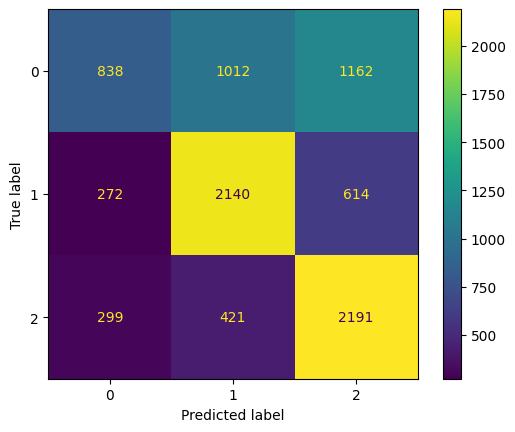

In [ ]:
#@title Get confusion matrix (new)

print("Classification Report (Entire Dataset):")
print(classification_report(test_target, pred_target))
print("Confusion Matrix (Entire Dataset):")
print(confusion_matrix(test_target, pred_target))
cm_target = confusion_matrix(test_target, pred_target)
print("Confusion Matrix - Entire Dataset:")
ConfusionMatrixDisplay(cm_target).plot()

In [ ]:
#@title Save VC
%cd -
joblib.dump(voting_classifier, 'voting_classifier.pkl')

In [68]:
#@title Save results as csv
res_df=df.iloc[list(test_target.index)][['close', 'target']]
is_equal=res_df['target'].equals(test_target)
print(f"Check if targets equals: {is_equal}")
res_df['pred_target']=pred_target
res_df.to_csv('res_df.csv')

In [ ]:
#@title Load VC
voting_classifier=joblib.load('voting_classifier.pkl')

#Result analysis


*   Determine the levels of SL and TP
*   Based on the determined levels, perform a full backtest



In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle as pk

In [3]:
res_df=pd.read_csv('res_df.csv')

In [42]:
is_open_long=False
is_open_short=False

pos_type=0
results=[]
count=0
price=0
start_long_idx=0
start_short_idx=0
for i in range(len(res_df)):
    res=res_df.iloc[i]
    if is_open_long:
        if res['pred_target']==2:
            count+=1
        elif res['pred_target']==0:
            count+=1
        elif res['pred_target']==1:
            count=0
    elif is_open_short:
        if res['pred_target']==1:
            count+=1
        elif res['pred_target']==0:
            count+=1
        elif res['pred_target']==2:
            count=0
    else:
        if res['pred_target']==1:
            is_open_long=True
            start_long_idx=i
            #print(res_df.iloc[i])
            price=res_df.iloc[i]['close']
            pos_type=1
            count=0
        elif res['pred_target']==2:
            start_short_idx=i
            is_open_short=True
            #print(res_df.iloc[i])
            price=res_df.iloc[i]['close']
            pos_type=2
            count=0
            #is_open_long=False

    if count==4:
        if pos_type==1:

            is_open_long=False
            c_price=res_df.iloc[i]['close']

            results.append([start_long_idx,
                            i,
                            pos_type,
                            price,
                            c_price,
                            c_price-price,
                            (1000/price)*c_price])

            pos_type=0
            count=0

        elif pos_type==2:
            is_open_short=False

            c_price=res_df.iloc[i]['close']

            results.append([start_short_idx,
                            i,
                            pos_type,
                            price,
                            c_price,
                            price-c_price,
                            (1000/price)*c_price])

            pos_type=0
            count=0




In [43]:
resss=pd.DataFrame(results, columns=['open_idx','close_idx','pos_type', 'price', 'close', 'diff', 'profit'])

In [48]:
resss.to_csv('results_buy_every_time.csv')

In [5]:
resss['profit'].sum()

619265.4047151163

In [6]:
resss['diff'].sum()

-15799.0

In [66]:
resss['diff'].iloc[:100].sum()

7930.0

In [11]:
results

[[0, 10, 1, 56291.0, 56686.0, 395.0, 1007.0171075305111],
 [11, 19, 1, 56812.0, 56853.0, 41.0, 1000.7216785186228],
 [20, 30, 2, 56794.0, 57130.0, -336.0, 1005.9161178997782],
 [31, 35, 2, 57030.0, 57523.0, -493.0, 1008.6445730317378],
 [36, 80, 2, 57356.0, 55108.0, 2248.0, 960.8061929004812],
 [81, 98, 2, 55001.0, 55612.0, -611.0, 1011.1088889292922],
 [99, 110, 1, 57292.0, 57030.0, -262.0, 995.4269356978288],
 [111, 117, 2, 56852.0, 56952.0, -100.0, 1001.7589530711322],
 [118, 142, 1, 57137.0, 57109.0, -28.0, 999.5099497698515],
 [143, 189, 1, 58025.0, 61418.0, 3393.0, 1058.4747953468332],
 [190, 197, 2, 61541.0, 61355.0, 186.0, 996.9776246729822],
 [198, 212, 2, 61267.0, 60988.0, 279.0, 995.4461618816001],
 [213, 230, 1, 60875.0, 60632.0, -243.0, 996.0082135523614],
 [231, 257, 2, 60359.0, 60480.0, -121.0, 1002.0046720455939],
 [258, 299, 1, 60384.0, 60436.0, 52.0, 1000.86115527292],
 [300, 309, 1, 60443.0, 60411.0, -32.0, 999.4705755836078],
 [311, 327, 1, 60474.0, 60816.0, 342.0, 

In [29]:
resss.iloc[:100]['diff'].sum()

7930.0

Ensemble Accuracy: 0.66
Classification Report (Entire Dataset):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.65      0.80      0.72        40
           2       0.67      0.87      0.76        39

    accuracy                           0.66       100
   macro avg       0.44      0.56      0.49       100
weighted avg       0.52      0.66      0.58       100

Confusion Matrix (Entire Dataset):
[[ 0 12  9]
 [ 0 32  8]
 [ 0  5 34]]
Confusion Matrix - Entire Dataset:
Ensemble Accuracy: 0.6333333333333333
Classification Report (Entire Dataset):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        34
           1       0.65      0.79      0.71        63
           2       0.62      0.85      0.71        53

    accuracy                           0.63       150
   macro avg       0.42      0.55      0.48       150
weighted avg       0.49      0.63      0.55 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        46
           1       0.68      0.82      0.74        90
           2       0.62      0.88      0.72        64

    accuracy                           0.65       200
   macro avg       0.43      0.57      0.49       200
weighted avg       0.50      0.65      0.57       200

Confusion Matrix (Entire Dataset):
[[ 0 27 19]
 [ 0 74 16]
 [ 0  8 56]]
Confusion Matrix - Entire Dataset:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


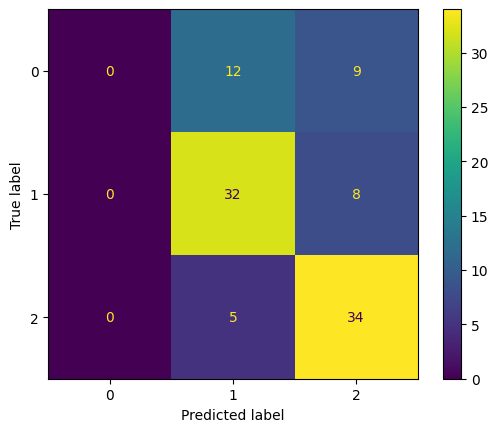

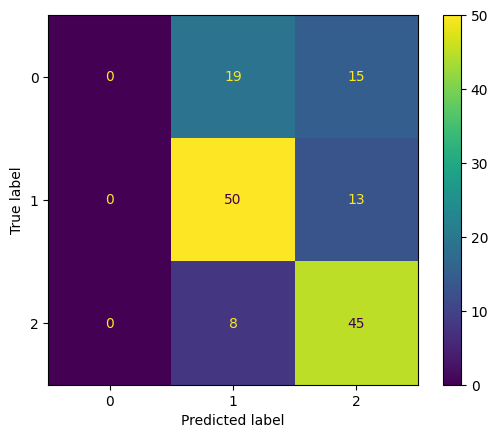

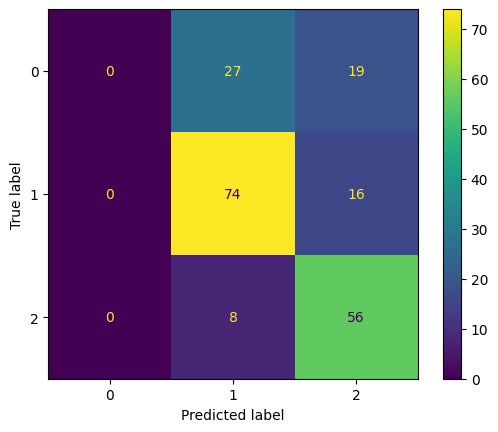

In [5]:
#@title Get confusion matrix (new)

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import ConfusionMatrixDisplay

test_target, pred_target = res_df[:100]['target'].values, res_df[:100]['pred_target'].values

accuracy = accuracy_score(test_target, pred_target)
print("Ensemble Accuracy:", accuracy)



print("Classification Report (Entire Dataset):")
print(classification_report(test_target, pred_target))
print("Confusion Matrix (Entire Dataset):")
print(confusion_matrix(test_target, pred_target))
cm_target = confusion_matrix(test_target, pred_target)
print("Confusion Matrix - Entire Dataset:")
ConfusionMatrixDisplay(cm_target).plot()



test_target, pred_target = res_df[:150]['target'].values, res_df[:150]['pred_target'].values

accuracy = accuracy_score(test_target, pred_target)
print("Ensemble Accuracy:", accuracy)



print("Classification Report (Entire Dataset):")
print(classification_report(test_target, pred_target))
print("Confusion Matrix (Entire Dataset):")
print(confusion_matrix(test_target, pred_target))
cm_target = confusion_matrix(test_target, pred_target)
print("Confusion Matrix - Entire Dataset:")
ConfusionMatrixDisplay(cm_target).plot()




test_target, pred_target = res_df[:200]['target'].values, res_df[:200]['pred_target'].values

accuracy = accuracy_score(test_target, pred_target)
print("Ensemble Accuracy:", accuracy)



print("Classification Report (Entire Dataset):")
print(classification_report(test_target, pred_target))
print("Confusion Matrix (Entire Dataset):")
print(confusion_matrix(test_target, pred_target))
cm_target = confusion_matrix(test_target, pred_target)
print("Confusion Matrix - Entire Dataset:")
ConfusionMatrixDisplay(cm_target).plot()

Ensemble Accuracy: 0.57
Classification Report (Entire Dataset):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.61      0.79      0.69        38
           2       0.54      0.77      0.64        35

    accuracy                           0.57       100
   macro avg       0.38      0.52      0.44       100
weighted avg       0.42      0.57      0.48       100

Confusion Matrix (Entire Dataset):
[[ 0 12 15]
 [ 0 30  8]
 [ 1  7 27]]
Confusion Matrix - Entire Dataset:


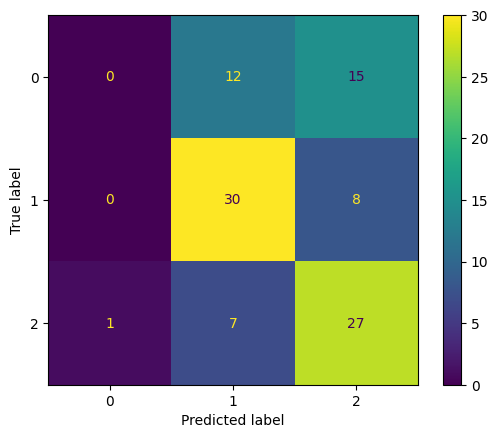

In [58]:
test_target, pred_target = res_df[600:700]['target'].values, res_df[600:700]['pred_target'].values

accuracy = accuracy_score(test_target, pred_target)
print("Ensemble Accuracy:", accuracy)



print("Classification Report (Entire Dataset):")
print(classification_report(test_target, pred_target))
print("Confusion Matrix (Entire Dataset):")
print(confusion_matrix(test_target, pred_target))
cm_target = confusion_matrix(test_target, pred_target)
print("Confusion Matrix - Entire Dataset:")
ConfusionMatrixDisplay(cm_target).plot()

In [45]:
resss.head()

,open_idx,close_idx,pos_type,price,close,diff,profit
0,0,10,1,56291.0,56686.0,395.0,1007.017108
1,11,19,1,56812.0,56853.0,41.0,1000.721679
2,20,30,2,56794.0,57130.0,-336.0,1005.916118
3,31,35,2,57030.0,57523.0,-493.0,1008.644573
4,36,80,2,57356.0,55108.0,2248.0,960.806193


In [7]:
res_df.head(30)

,Unnamed: 0,close,target,pred_target
0,20880,56291.0,1,1
1,20881,55888.0,1,2
2,20882,56205.0,1,1
3,20883,56561.0,1,1
4,20884,56940.0,1,1
5,20885,56721.0,1,1
6,20886,57156.0,0,1
7,20887,56714.0,2,2
8,20888,56717.0,2,2
9,20889,56808.0,2,2


In [6]:
long_arr=[]
long_df=resss[resss['pos_type']==1]
short_df=resss[resss['pos_type']==2]
for i in range(len(long_df)):  #resss[resss['pos_type']==1]:
    row=long_df.iloc[i]
    open=int(row['open_idx'])
    close=int(row['close_idx'])

    long_arr.append(res_df.iloc[open:close]['close'])
    #break

short_arr=[]
for i in range(len(short_df)):  #resss[resss['pos_type']==1]:
    row=short_df.iloc[i]
    open=int(row['open_idx'])
    close=int(row['close_idx'])

    short_arr.append(res_df.iloc[open:close]['close'])
    #break

In [7]:
long_diff_tp=np.array([((i.values.max()-i.values[0])/i.values[0])*100 for i in long_arr])
long_diff_sl=np.array([((i.values.min()-i.values[0])/i.values[0])*100 for i in long_arr])

short_diff_tp=np.array([((i.values[0]-i.values.min())/i.values[0])*100 for i in short_arr])
short_diff_sl=np.array([((i.values[0]-i.values.max())/i.values[0])*100 for i in short_arr])

#for i in buy_arr



In [12]:
long_diff_sl.mean()

-0.2855932370345401

In [8]:
long_diff_tp.mean()

0.5030962082503156

In [39]:
((long_diff_sl.mean()-long_diff_sl.std())**2)**(1/3)

0.7460460217271001

In [34]:
((long_diff_tp.mean()-long_diff_tp.std())**2)**(1/3)
#long_diff_sl

0.5235434303544394

In [31]:
long_diff_tp.mean()-long_diff_tp.std()

-0.37881666066371666

In [19]:
short_diff_tp.mean()

0.5202774552815467

In [20]:
short_diff_sl.mean()

-0.3401802092014908

In [54]:
diff_dict={"long_diff_tp": long_diff_tp,
            "long_diff_sl": long_diff_sl,
            "short_diff_tp" : short_diff_tp,
            "short_diff_sl": short_diff_sl}

In [65]:
price*0.05

3788.7000000000003